# Structural Variant Discovery and Analysis
Structural variant (SV) analyses followed a similar pipeline where variant discovery, variant quality filtering, and initial genotyping was performed under recommended pipelines. High quality genotypes representing homozygous reference, heterozygous and homozygous alternate calls were then plotted with SAMplot and evaluated using PlotCritic for call refinement. Calls passing evaluation with PlotCritic were then merged using SURVIVOR and used to construct a genome graph with the VG tools suite. Detailed methods for each of these steps using Delly, and Smoove are outlined below.  

## Variant Discovery
###
[Manta](https://github.com/Illumina/manta) v1.6.0 was used to call SVs for Australian fairy tern and tara iti. Three samples had to be excluded for to run, AU13, TI06, TI34 & TI35. The errors indicated issues with the proportion of reads and read depth statistics. Each chromosome was called independently with the `--callRegions` flag to save computational resource and increase efficiency. Five samples did not pass [Manta's read-pair orientation threshold](https://github.com/Illumina/manta/issues/168) of 90% and were excluded from SV discovery. This included two Australian samples and three tara iti samples (AU08, AU13, SND11, TI35).

Running Manta is relatively simple, with the initial configuration setup for each individual chromosome and executed each run. Because Manta outputs inversions as breakends ([see here](https://github.com/Illumina/manta/blob/master/docs/userGuide/README.md)), Inversion calls were converted from Breakends using the `convertInversions.py` script supplied by Manta. It is best to do this step on the individual output files before merging into a single file.  

Once individual chromosome runs were complete, VCFs were concatenated into a single file for SV quality filtering. 

### SMOOVE


Merging calls

## Filtering Initial Calls
### Manta
For filtering raw Manta calls, all reads had to pass all 'hard' filtering thresholds and have 'PRECISE' breakpoints.  

In [ ]:
bcftools view -i 'FILTER=="PASS" & IMPRECISE==0' \
    -O z -o manta/03_fairy_filtered.vcf.gz manta/02_fairy_SVcalls_INVconverted.vcf
bcftools index manta/03_fairy_filtered.vcf.gz

bcftools view -i 'FILTER=="PASS" & IMPRECISE==0' \
    -O z -o manta/03_kaki_filtered.vcf.gz manta/02_kaki_SVcalls_INVconverted.vcf
bcftools index manta/03_kaki_filtered.vcf.gz

## Genotyping
### Manta
We used graphtyper2 to genotype Manta SV calls as per:

In [ ]:
while read -r line
    do
    printf "STARTED GENOTYPING $line AT "
    date
    graphtyper genotype_sv reference/SP01_5kb_ragtag.fa manta/03_fairy_filtered.vcf.gz --sams=fairy.list --threads=16 --region=$line
done < fairy_chroms.tsv

This genotyping and filtering approach was repeated for both kakī datasets.  

|   SV Type   | Raw FT Genotypes | Filtered FT Genotypes | KĪ 50x Genotypes | KĪ 50x GenoFiltered | KĪ 10x Genotypes | KĪ 10x GenoFiltered |
|:-----------:|:----------------:|:---------------------:|:----------------:|:-------------------:|:----------------:|:-------------------:|
|  Deletion   |       5,948      |         1,087         |       6,912      |         533         |      6,299       |         308         |
| Duplication |        450       |           41          |         674      |          15         |       561        |           7         |
|  Insertion  |       3,659      |         1,544         |       5,304      |        1,192        |      4,431       |         724         |
|  Inversion  |        486       |           0           |         61       |          0          |        49        |          0          |
|    Total    |      10,543      |         2,672         |      12,951      |        1,740        |     11,340       |        1,039        |

### SMOOVE
Genotyping

## Genotype Filtering
### Manta
Genotypes for individual chromosomes were then merged and filtered to include SVs that passed in the `AGGREGATED` genotyping model for graphtyper and had a mean GQ>=25.

### SMOOVE

## SV Evaluation
### Manta
Genotypes were visually inspected for support by plotting with SAMplot and scoring with [PlotCritic](https://github.com/jbelyeu/PlotCritic). As with Smeds et al. only one curator was used to prevent the overfiltering of genotypes. We used BCFtools to first extract regions of interest for each individual.

These regions were then plotted into individual folders with SAMPLOT for each dataset.  

We then created PlotCritic projects and manually scored all SV genotypes.  

Scored genotypes were then extracted from the PlotCritic Summary files upon completion of scoring

The number counts of each genotype for each individual were then acquired as below.

## Structural Variant Characteristics
### Insights from high coverage data for kakī
To explore the effect of read depth on SV discovery, we leverage the kakī data by performing SV discovery with Manta using all aligned reads for each individual, and again after randomly subsampling the alignment files to mirror alignment depths observed in the tara iti data set (e.g., ~5x - 13x coverage). Below we plot comparisons between all SVs discovered, and those that passes initial filtering thresholds in both of these data sets.  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu
from scipy import stats

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


In [ ]:
kiSV_overlap = pd.read_csv('manta/KI_sv_overlap_summary.tsv', sep='\t')
kiSV_gts = pd.read_csv('graphtyper/KI_genotype_SVsummaries.tsv', sep='\t')

order = ['Subset Alignments', 'High Coverage Alignments', 'Filtered Subset Alignments', 'Filtered High Coverage Alignments', 'Subset x High Coverage Alignments', 'Filtered Subset x High Coverage', 'Filtered Subset x Filtered High Coverage']
kiSV_overlap['Data Set'] = pd.Categorical(kiSV_overlap['Data Set'], categories=order, ordered=True)
kiSV_gts['Data Set'] = pd.Categorical(kiSV_gts['Data Set'], ordered=True)

kiSV_overlap_pivot = kiSV_overlap.pivot_table(index='Data Set', columns='SV Type', values='Count', fill_value=0)
kiSV_gts_pivot = kiSV_gts.pivot_table(index='Data Set', columns='SV Type', values='Count', fill_value=0)

kiSV_gts_pivot.head()

In [ ]:
kiSV_overlap_pivot.plot(kind='bar', stacked=True, color=['#0173b2', '#de8f05', '#029e73', '#d55e00'], figsize=(20,10))

plt.savefig('plots/KI_SVdiscovery_overlaps.pdf', dpi=300, bbox_inches='tight')

We then counted the number of SVs passing genotyping thresholds. This was done in 3 ways: 
1. SVs called and genotyped with the subsampled data (10x SVs, 10x GTs)
2. SVs called with the high coverage and genotyped with the subsampled data (50x SVs, 10x GTs) 
3. SVs called and genotyped with high coverage data (50x SVs, 50x GTs)

In [ ]:
kiSV_gts_pivot.plot(kind='bar', stacked=True, color=['#0173b2', '#de8f05', '#029e73', '#d55e00'], figsize=(20,10))
plt.savefig('plots/KI_SVgenotype_summary.pdf', dpi=300, bbox_inches='tight')

### Implications of read depth for heterozygosity estimates
Here we are comparing individual heterozygosity for SVs called and genotyped with high coverage data, SVs called with high coverage data and genotyped with a subset of aligned read depth, and finally SVs called and genotyped with subset data.  


In [ ]:
sv_supp_het = pd.read_csv('graphtyper/individual_svHet.tsv', delimiter='\t')
sv_supp_het = sv_supp_het[sv_supp_het['Population']!='50xSVs_50xGTs']
sv_supp_het.head()

### Count Comparisons
Next we examine the number of SVs by type found within the fairy tern species complex and each of the kakī data sets examined here. We first counted the total Number of SVs found in Manta, those passing SV quality threshold and used as input for genotyping and finally those that passed genotyping filters. 

In [3]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiLCSVs = SVs[SVs['Population']=='KI_10x']
kiSVs = SVs[SVs['Population']=='KI']

SVs.head()

,Chromosome,Position,SV Type,Length,Dataset,Population
0,CM020437.1_RagTag,117049698,BND,.,Smoove Unfiltered,AU
1,CM020438.1_RagTag,32387641,BND,.,Smoove Unfiltered,AU
2,CM020437.1_RagTag,124552108,BND,.,Smoove Unfiltered,AU
3,CM020438.1_RagTag,167204298,BND,.,Smoove Unfiltered,AU
4,CM020437.1_RagTag,153678011,BND,.,Smoove Unfiltered,AU


In [4]:
print(sns.color_palette('colorblind').as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


/tmp/ipykernel_22318/1798458708.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
/tmp/ipykernel_22318/1798458708.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3,0].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
/tmp/ipykernel_22318/1798458708.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)


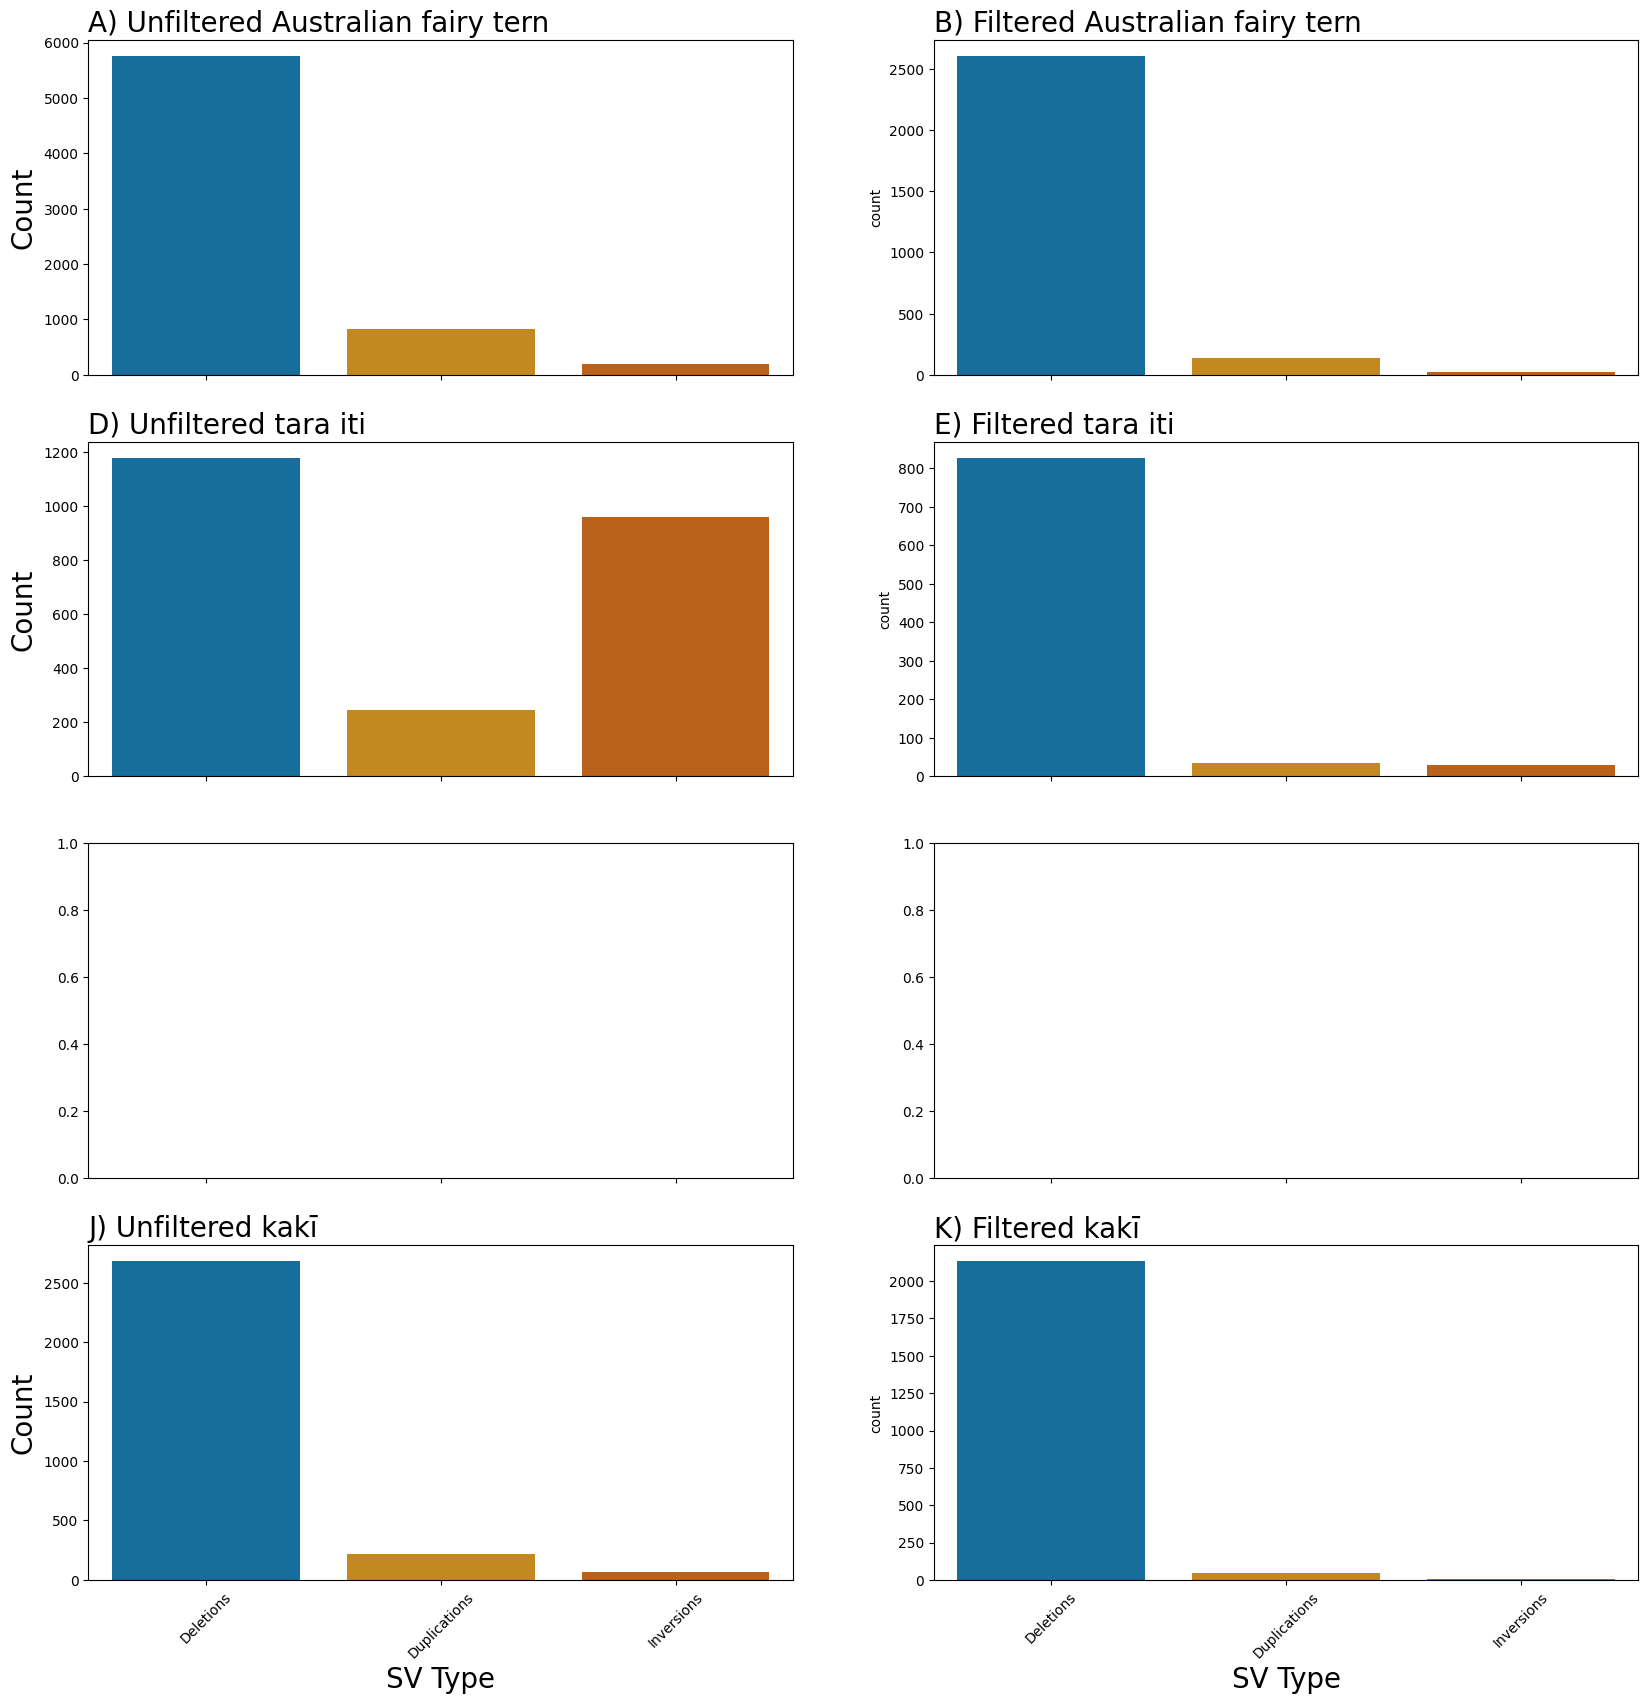

In [9]:
palette = {
    'BND': '#56b4e9',
    'DEL': '#0173b2',
    'DUP': '#de8f05',
    'INV': '#d55e00'
}
order = ['DEL', 'DUP', 'INV']

fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharex=True, sharey=False)

sns.countplot(auSVs[auSVs['Dataset']=='Smoove Unfiltered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[0,0])
axes[0,0].set_title('A) Unfiltered Australian fairy tern', fontsize=20, loc='left')
axes[0,0].set_ylabel('Count', fontsize=20)
#axes[0,0].set_ylim(0, 14000)
sns.countplot(auSVs[auSVs['Dataset']=='Smoove filtered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[0,1])
axes[0,1].set_title('B) Filtered Australian fairy tern', fontsize=20, loc='left')
axes[0,1].set_xlabel('SV Type', fontsize=20)
axes[0,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
#axes[0,1].set_ylim(0, 1700)

sns.countplot(tiSVs[tiSVs['Dataset']=='Smoove Unfiltered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[1,0])
axes[1,0].set_title('D) Unfiltered tara iti', fontsize=20, loc='left')
axes[1,0].set_ylabel('Count', fontsize=20)
#axes[1,0].set_ylim(0, 14000)
sns.countplot(tiSVs[tiSVs['Dataset']=='Smoove filtered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[1,1])
axes[1,1].set_title('E) Filtered tara iti', fontsize=20, loc='left')
#axes[1,1].set_ylim(0, 1700)

#sns.countplot(kiLCSVs[kiLCSVs['Dataset']=='Unfiltered Manta'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[2,0])
#axes[2,0].set_title('G) Unfiltered low coverage kakī', fontsize=20, loc='left')
#axes[2,0].set_ylabel('Count', fontsize=20)
#axes[2,0].set_ylim(0, 14000)
#sns.countplot(kiLCSVs[kiLCSVs['Dataset']=='Filtered Manta'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[2,1])
#axes[2,1].set_title('H) Filtered low coverage kakī', fontsize=20, loc='left')
#axes[2,1].set_xlabel('SV Type', fontsize=20)
#axes[2,1].set_ylim(0, 1700)

sns.countplot(kiSVs[kiSVs['Dataset']=='Smoove Unfiltered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[3,0])
axes[3,0].set_title('J) Unfiltered kakī', fontsize=20, loc='left')
axes[3,0].set_ylabel('Count', fontsize=20)
axes[3,0].set_xlabel('SV Type', fontsize=20)
axes[3,0].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
#axes[3,0].set_ylim(0, 14000)
sns.countplot(kiSVs[kiSVs['Dataset']=='Smoove filtered'], x='SV Type', hue='SV Type', order=order, palette=palette, ax=axes[3,1])
axes[3,1].set_title('K) Filtered kakī', fontsize=20, loc='left')
axes[3,1].set_xlabel('SV Type', fontsize=20)
axes[3,1].set_xticklabels(['Deletions', 'Duplications', 'Inversions'], rotation=45)
#axes[3,1].set_ylim(0, 1700)

plt.savefig('TI_ms_plots/SV_counts.png', dpi=300, bbox_inches='tight')

Counts per chromosome

FileNotFoundError: [Errno 2] No such file or directory: 'plots/SV_chr_counts.png'

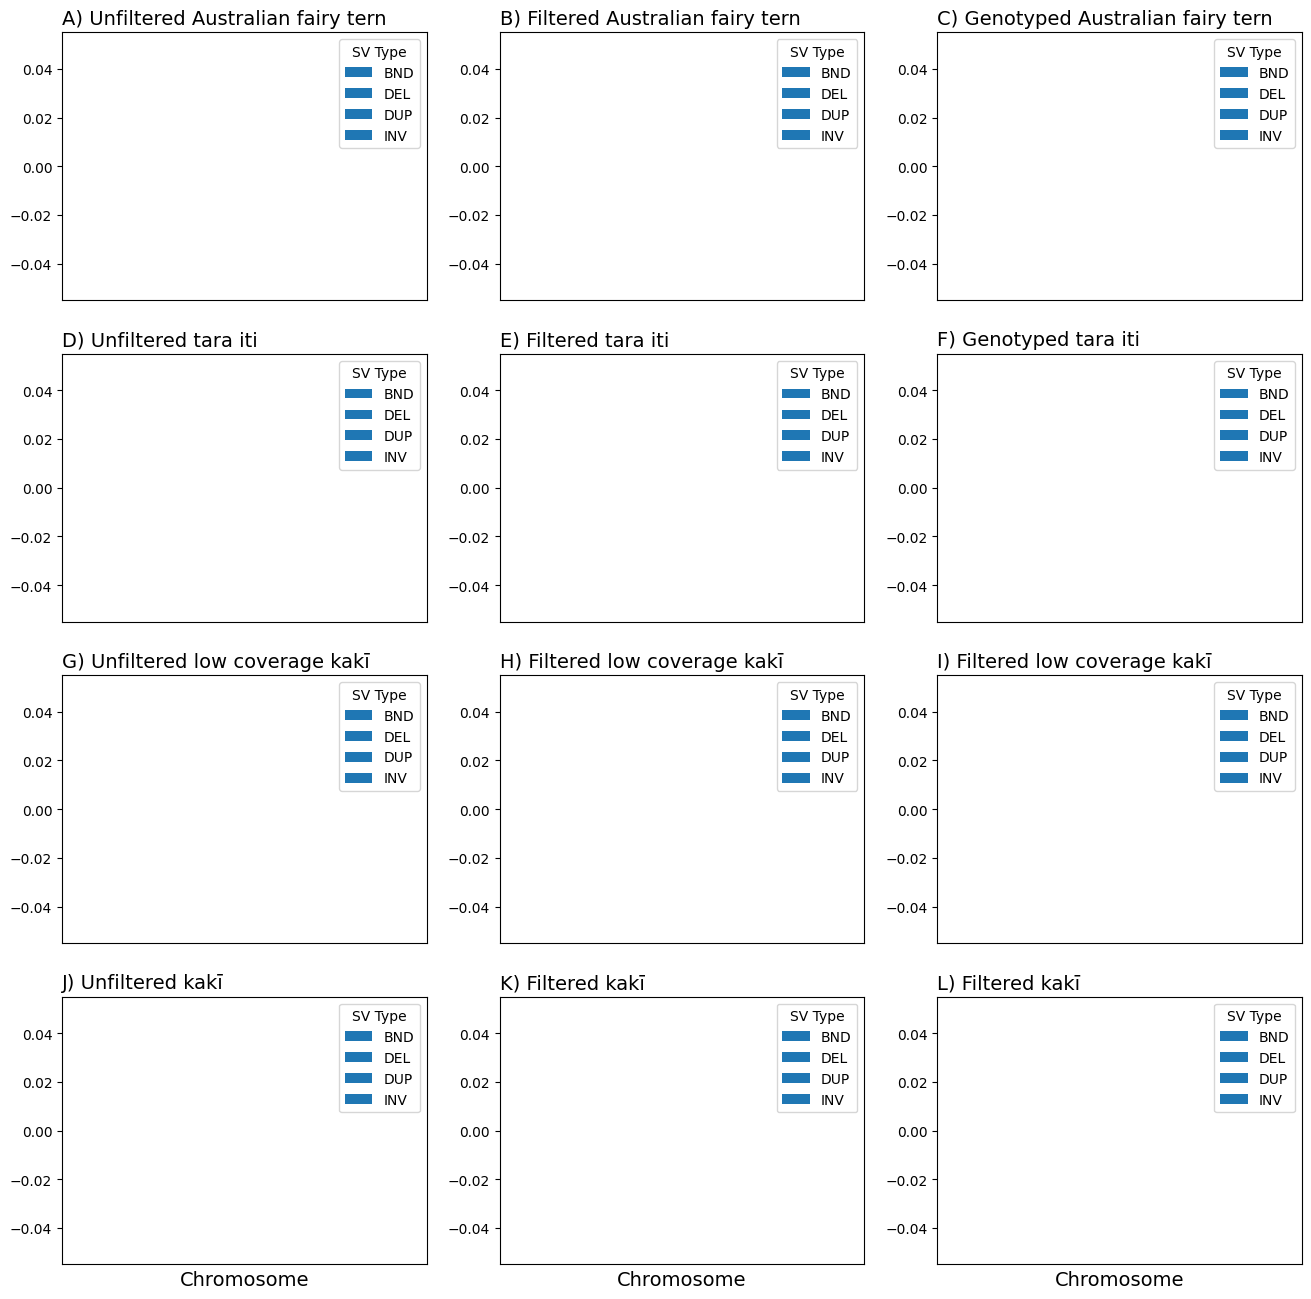

In [10]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiLCSVs = SVs[SVs['Population']=='KI_10x']
kiSVs = SVs[SVs['Population']=='KI']

palette = {
    'BND': '#56b4e9',
    'DEL': '#0173b2',
    'DUP': '#de8f05',
    'INS': '#029e73',
    'INV': '#d55e00'
}
order = ['BND', 'DEL', 'DUP', 'INV']

def plot_stacked_bar(data, dataset, ax, title):
    crosstab = pd.crosstab(data[data['Dataset'] == dataset]['Chromosome'], data[data['Dataset'] == dataset]['SV Type']).reindex(columns=order, fill_value=0)
    bottom = np.zeros(len(crosstab))
    for sv_type in order:
        ax.bar(crosstab.index, crosstab[sv_type], bottom=bottom, label=sv_type, color=palette[sv_type])
        bottom += crosstab[sv_type]
    ax.set_title(title, fontsize=14, loc='left')
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.legend(title='SV Type')

fig, axes = plt.subplots(4, 3, figsize=(16, 16), sharex=False, sharey=False)

plot_stacked_bar(auSVs, 'Unfiltered Manta', axes[0,0], 'A) Unfiltered Australian fairy tern')
plot_stacked_bar(auSVs, 'Filtered Manta', axes[0,1], 'B) Filtered Australian fairy tern')
plot_stacked_bar(auSVs, 'Genotyped', axes[0,2], 'C) Genotyped Australian fairy tern')
plot_stacked_bar(tiSVs, 'Unfiltered Manta', axes[1,0], 'D) Unfiltered tara iti')
plot_stacked_bar(tiSVs, 'Filtered Manta', axes[1,1], 'E) Filtered tara iti')
plot_stacked_bar(tiSVs, 'Genotyped', axes[1,2], 'F) Genotyped tara iti')
plot_stacked_bar(kiLCSVs, 'Unfiltered Manta', axes[2,0], 'G) Unfiltered low coverage kakī')
plot_stacked_bar(kiLCSVs, 'Filtered Manta', axes[2,1], 'H) Filtered low coverage kakī')
plot_stacked_bar(kiLCSVs, 'Genotyped', axes[2,2], 'I) Filtered low coverage kakī')
plot_stacked_bar(kiSVs, 'Unfiltered Manta', axes[3,0], 'J) Unfiltered kakī')
plot_stacked_bar(kiSVs, 'Filtered Manta', axes[3,1], 'K) Filtered kakī')
plot_stacked_bar(kiSVs, 'Genotyped', axes[3,2], 'L) Filtered kakī')

axes[3,0].set_xlabel('Chromosome', fontsize=14)
axes[3,1].set_xlabel('Chromosome', fontsize=14)
axes[3,2].set_xlabel('Chromosome', fontsize=14)

plt.savefig('plots/SV_chr_counts.png', dpi=300, bbox_inches='tight')

As this plot demonstrates, the vast majority of Deletions were called on chromosome 1 in fairy terns and kakī. For fairy terns, deletions were only called on three other chromosomes (corresponding to chromosome 2, 3, and 12), while there were deletions called on nine other chromosomes in kakī (corresponding to chromosomes 2, 3, 6, 9, 11, 12, 13, 24, and 27). In contrast, insertions were more consistently distributed among individuals chromosomes and the number of insertions generally corresponded to chromosome size. The distribution of duplications is more challenging to infer as they are very infrequent in either data set, but were only genotyped on two individuals chromosomes in either case. 

### Proportion of chromosome impacted
As above, we plot the number of SVs per chromosome while accounting for aggregate number of base-pairs impacted relative to chromosome size.  

In [33]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[(SVs['SV Type']!='.') & (SVs['SV Length']!='.')]
SVs['SV Length'] = SVs['SV Length'].astype(int)

ti_chromLength = pd.read_csv('new_TI/hifiasm_longstitch_racon_ragtag/autosomes.bed', delimiter = '\t', names=['Chromosome', 'Start', 'Total Chr Length'])
ti_chromLength = ti_chromLength[['Chromosome', 'Total Chr Length']]
ki_chromLength = pd.read_csv('kaki_genome/kaki_autosomes.bed', delimiter = '\t', names=['Chromosome', 'Start', 'Total Chr Length'])
ti_chromLength = ti_chromLength[['Chromosome', 'Total Chr Length']]

SV_prop = SVs.groupby(['Chromosome', 'SV Type', 'Population', 'Dataset'])['SV Length'].sum().reset_index(name='Total SV Length')

auSV_prop = SV_prop[SV_prop['Population']=='AU']
tiSV_prop = SV_prop[SV_prop['Population']=='TI']
kiLCSV_prop = SV_prop[SV_prop['Population']=='KI_10x']
kiSV_prop = SV_prop[SV_prop['Population']=='KI']

tiSV_prop.head()

,Chromosome,SV Type,Population,Dataset,Total SV Length
2,CM020437.1_RagTag,DEL,TI,Smoove Unfiltered,4891872
3,CM020437.1_RagTag,DEL,TI,Smoove filtered,333458
6,CM020437.1_RagTag,DUP,TI,Smoove Unfiltered,4088073
7,CM020437.1_RagTag,DUP,TI,Smoove filtered,17849
10,CM020437.1_RagTag,INV,TI,Smoove Unfiltered,2563083


In [36]:
auSV_prop = pd.merge(auSV_prop, ti_chromLength, on=['Chromosome'])
tiSV_prop = pd.merge(tiSV_prop, ti_chromLength, on=['Chromosome'])
kiLCSV_prop = pd.merge(kiLCSV_prop, ki_chromLength, on=['Chromosome'])
kiSV_prop = pd.merge(kiSV_prop, ki_chromLength, on=['Chromosome'])

auSV_prop['Chr Proportion'] = auSV_prop['Total SV Length'] / auSV_prop['Total Chr Length']
tiSV_prop['Chr Proportion'] = tiSV_prop['Total SV Length'] / tiSV_prop['Total Chr Length']
kiLCSV_prop['Chr Proportion'] = kiLCSV_prop['Total SV Length'] / kiLCSV_prop['Total Chr Length']
kiSV_prop['Chr Proportion'] = kiSV_prop['Total SV Length'] / kiSV_prop['Total Chr Length']

kiSV_prop[tiSV_prop['Dataset']=='Smoove filtered'].head()

KeyError: 'Total Chr Length'

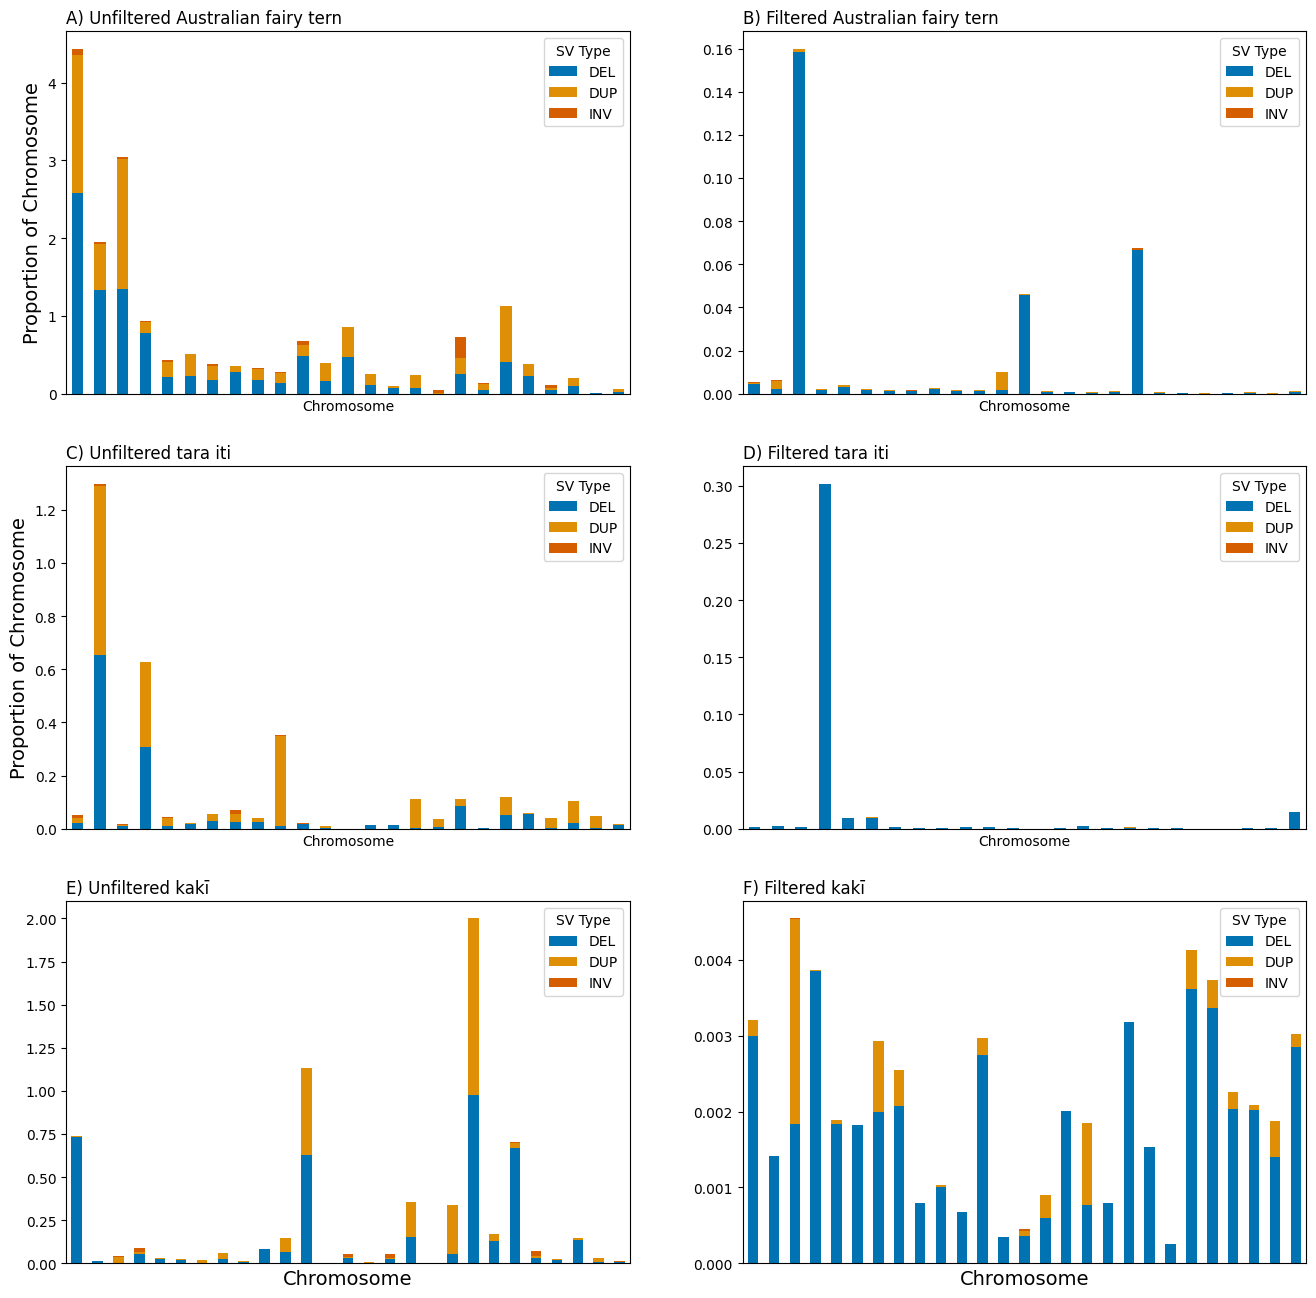

In [39]:
palette = {
    'BND': '#56b4e9',
    'DEL': '#0173b2',
    'DUP': '#de8f05',
    'INS': '#029e73',
    'INV': '#d55e00'
}
order = ['BND', 'DEL', 'DUP', 'INV']

def plot_stacked_bar(df, dataset_filter, ax, title):
    df_filtered = df[df['Dataset'] == dataset_filter]
    pivot_df = df_filtered.pivot(index='Chromosome', columns='SV Type', values='Chr Proportion')
    pivot_df = pivot_df.fillna(0)
    
    pivot_df.plot(kind='bar', stacked=True, color=[palette.get(x) for x in pivot_df.columns], ax=ax)
    
    ax.set_title(title, fontsize=12, loc='left')
    ax.set_xticks([])
    ax.legend(title='SV Type')

fig, axes = plt.subplots(3, 2, figsize=(16, 16), sharex=False, sharey=False)

plot_stacked_bar(auSV_prop, 'Smoove Unfiltered', axes[0,0], 'A) Unfiltered Australian fairy tern')
plot_stacked_bar(auSV_prop, 'Smoove filtered', axes[0,1], 'B) Filtered Australian fairy tern')
plot_stacked_bar(tiSV_prop, 'Smoove Unfiltered', axes[1,0], 'C) Unfiltered tara iti')
plot_stacked_bar(tiSV_prop, 'Smoove filtered', axes[1,1], 'D) Filtered tara iti')
#plot_stacked_bar(kiLCSV_prop, 'Smoove Unfiltered', axes[2,0], 'G) Unfiltered low coverage kakī')
#plot_stacked_bar(kiLCSV_prop, 'Smoove filtered', axes[2,1], 'H) Filtered low coverage kakī')
plot_stacked_bar(kiSV_prop, 'Smoove Unfiltered', axes[2,0], 'E) Unfiltered kakī')
plot_stacked_bar(kiSV_prop, 'Smoove filtered', axes[2,1], 'F) Filtered kakī')

axes[2,0].set_xlabel('Chromosome', fontsize=14)
axes[2,1].set_xlabel('Chromosome', fontsize=14)
axes[0,0].set_ylabel('Proportion of Chromosome', fontsize=14)
axes[1,0].set_ylabel('Proportion of Chromosome', fontsize=14)

plt.savefig('TI_ms_plots/SV_chr_props.png', dpi=300, bbox_inches='tight')

In [ ]:
SV_filtered = SVs[SVs['Dataset']=='Filtered']
SV_filtered['SV Length'] = SV_filtered['SV Length'].astype(int)
SV_filtered.groupby('Population')['SV Length'].sum().reset_index(name='Total BP Impacted')

### SV Length Distributions

Text(0.5, 0, 'SV Length')

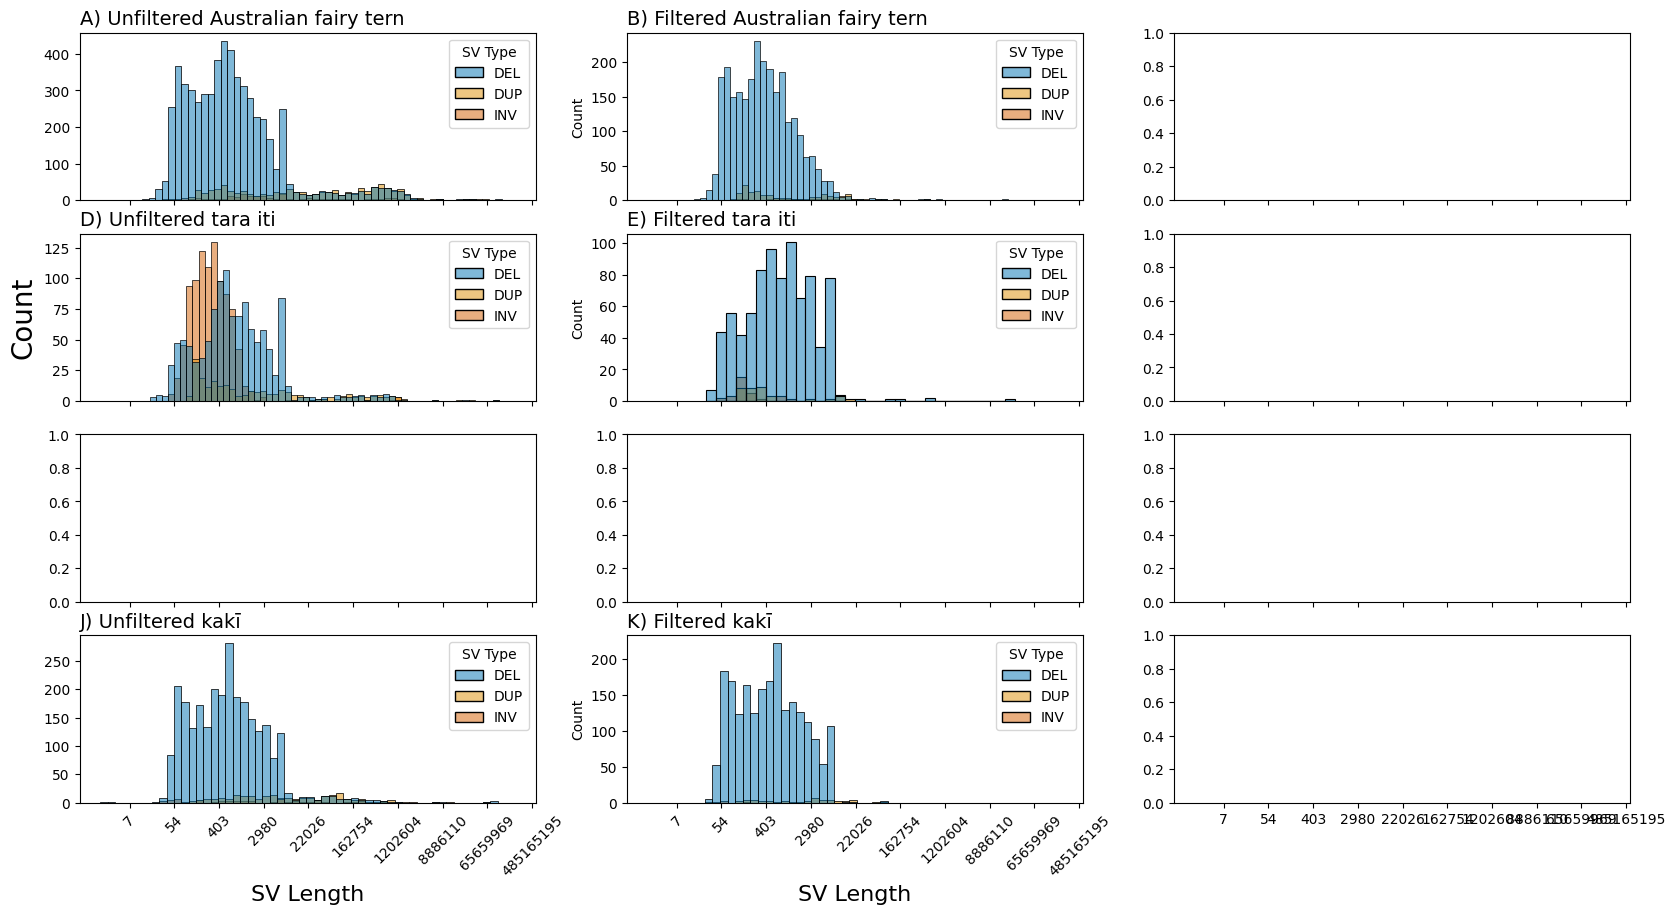

In [20]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']
SVs['SV Length'] = pd.to_numeric(SVs['SV Length'], errors='coerce')
SVs['Log Length'] = np.log(SVs['SV Length'])

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiLCSVs = SVs[SVs['Population']=='KI_10x']
kiSVs = SVs[SVs['Population']=='KI']

palette = {'DEL': '#0173b2', 'DUP': '#de8f05', 'INV': '#d55e00'}
order = ['DEL', 'DUP', 'INV']
populations = {'AU': auSVs, 'TI': tiSVs, 'KI_10x':kiLCSVs, 'KI': kiSVs}
titles = {'AU': 'Australian fairy tern', 'TI': 'tara iti', 'KI_10x': 'low coverage kakī', 'KI': 'kakī'}

fig, axes = plt.subplots(4, 3, figsize=(20, 10), sharex=True, sharey=False)

x_ticks_log = np.arange(2, 22, 2)
x_labels = np.exp(x_ticks_log).astype(int)

sns.histplot(auSVs[auSVs['Dataset'] == 'Smoove Unfiltered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[0, 0])
axes[0, 0].set_title('A) Unfiltered Australian fairy tern', fontsize=14, loc='left')
axes[0, 0].set_xticks(x_ticks_log)
axes[0, 0].set_ylabel('')
#axes[0, 0].set_ylim(0, 950)
sns.histplot(auSVs[auSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[0, 1])
axes[0, 1].set_title('B) Filtered Australian fairy tern', fontsize=14, loc='left')
axes[0, 1].set_xticks(x_ticks_log)
#axes[0, 1].set_ylim(0, 300)

sns.histplot(tiSVs[tiSVs['Dataset'] == 'Smoove Unfiltered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[1, 0])
axes[1, 0].set_title('D) Unfiltered tara iti', fontsize=14, loc='left')
axes[1, 0].set_xticks(x_ticks_log)
axes[1, 0].set_ylabel('Count', fontsize=20)
#axes[1, 0].set_ylim(0, 950)
sns.histplot(tiSVs[tiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[1, 1])
axes[1, 1].set_title('E) Filtered tara iti', fontsize=14, loc='left')
axes[1, 1].set_xticks(x_ticks_log)
#axes[1, 1].set_ylim(0, 300)

#sns.histplot(kiLCSVs[kiLCSVs['Dataset'] == 'Smoove Unfiltered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[2, 0])
#axes[2, 0].set_title('G) Unfiltered low coverage kakī', fontsize=14, loc='left')
#axes[2, 0].set_xticks(x_ticks_log)
#axes[2, 0].set_ylabel('')
#axes[2, 0].set_xticklabels(x_labels, rotation=45)
#axes[2, 0].set_xlabel('SV Length', fontsize=16)
#axes[2, 0].set_ylim(0, 950)
#sns.histplot(kiLCSVs[kiLCSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[2, 1])
#axes[2, 1].set_title('H) Filtered low coverage kakī', fontsize=14, loc='left')
#axes[2, 1].set_xticks(x_ticks_log)
#axes[2, 1].set_xticklabels(x_labels, rotation=45)
#axes[2, 1].set_xlabel('SV Length', fontsize=16)
#axes[2, 1].set_ylim(0, 300)

sns.histplot(kiSVs[kiSVs['Dataset'] == 'Smoove Unfiltered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[3, 0])
axes[3, 0].set_title('J) Unfiltered kakī', fontsize=14, loc='left')
axes[3, 0].set_xticks(x_ticks_log)
axes[3, 0].set_ylabel('')
axes[3, 0].set_xticklabels(x_labels, rotation=45)
axes[3, 0].set_xlabel('SV Length', fontsize=16)
#axes[3, 0].set_ylim(0, 950)
sns.histplot(kiSVs[kiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[3, 1])
axes[3, 1].set_title('K) Filtered kakī', fontsize=14, loc='left')
axes[3, 1].set_xticks(x_ticks_log)
axes[3, 1].set_xticklabels(x_labels, rotation=45)
axes[3, 1].set_xlabel('SV Length', fontsize=16)
#axes[3, 1].set_ylim(0, 300)


#plt.savefig('plots/Supp_Fig_SV_log_length_distributions.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'SV Length')

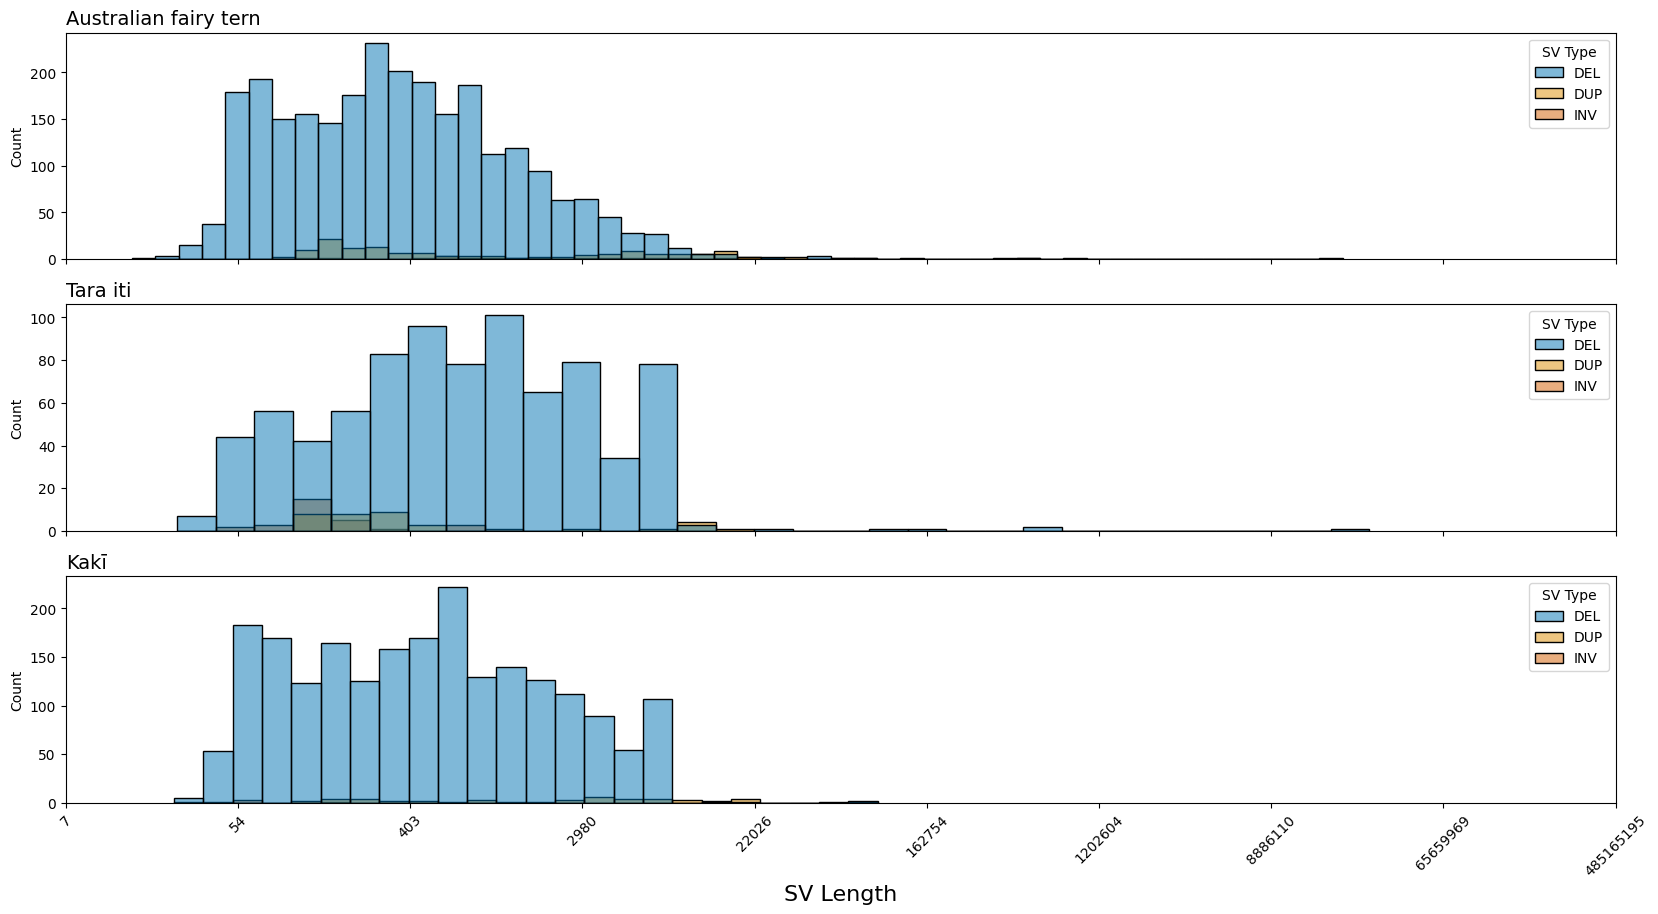

In [19]:
SVs = pd.read_csv('smoove/SV_characteristics.tsv', delimiter='\t')
SVs = SVs[SVs['SV Type']!='.']
SVs['SV Length'] = pd.to_numeric(SVs['SV Length'], errors='coerce')
SVs['Log Length'] = np.log(SVs['SV Length'])

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiLCSVs = SVs[SVs['Population']=='KI_10x']
kiSVs = SVs[SVs['Population']=='KI']

palette = {'DEL': '#0173b2', 'DUP': '#de8f05', 'INV': '#d55e00'}
order = ['DEL', 'DUP', 'INV']
populations = {'AU': auSVs, 'TI': tiSVs, 'KI_10x':kiLCSVs, 'KI': kiSVs}
titles = {'AU': 'Australian fairy tern', 'TI': 'tara iti', 'KI_10x': 'low coverage kakī', 'KI': 'kakī'}

fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, sharey=False)

x_ticks_log = np.arange(2, 22, 2)
x_labels = np.exp(x_ticks_log).astype(int)

sns.histplot(auSVs[auSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[0])
axes[0].set_title('Australian fairy tern', fontsize=14, loc='left')
axes[0].set_xticks(x_ticks_log)

sns.histplot(tiSVs[tiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[1])
axes[1].set_title('Tara iti', fontsize=14, loc='left')
axes[1].set_xticks(x_ticks_log)

sns.histplot(kiSVs[kiSVs['Dataset'] == 'Smoove filtered'], x='Log Length', hue='SV Type', palette=palette, hue_order=order, ax=axes[2])
axes[2].set_title('Kakī', fontsize=14, loc='left')
axes[2].set_xticks(x_ticks_log)
axes[2].set_xticklabels(x_labels, rotation=45)
axes[2].set_xlabel('SV Length', fontsize=16)

#plt.savefig('plots/Supp_Fig_SV_log_length_distributions.png', dpi=300, bbox_inches='tight')